In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn import metrics
import lightgbm as lgbm
from sklearn import metrics
import re
import pickle
from collections import Counter

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Все основные агрегаты считались в спарке

In [2]:
def memory_usage(df, name):
    mb = df.memory_usage().sum() / 1024 / 1024
    print(name + ' use {:.2f} mb in memory'.format(mb))

# TODO
* Нужно возвращаться к пачкам вопросов в смысле попыток. В разрезе контента по времени не влезаем.

# Загрузка данных

In [3]:
kaggle_data_path = './data'
#kaggle_data_path = '/kaggle/input'
# user_data_path = './data/spark_data_src'
user_data_path = './data/spark_data'
for dirname, _, filenames in os.walk(kaggle_data_path):
    for filename in filenames:
        current_file_path = os.path.join(dirname, filename)
        if 'lectures.csv' in current_file_path:
            lectures_path = current_file_path
        if 'questions.csv' in current_file_path:
            questions_path = current_file_path
        if 'train.csv' in current_file_path:
            data_path = current_file_path
#         print(current_file_path)

In [4]:
with open(os.path.join(user_data_path, 'train_data.pickle'), 'rb') as fo:
    train_data = pickle.load(fo)
memory_usage(train_data, 'train_data')
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    question_characteristics = pickle.load(fo)
memory_usage(question_characteristics, 'question_characteristics')
with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'rb') as fo:
    users_chars = pickle.load(fo)
memory_usage(users_chars, 'users_characteristics')
tags = ['first_user_answers', 'last_user_answers']
users_chars_valid = {}
valid_data = {}
for tag in tags:
    with open(os.path.join(user_data_path, 'users_characteristics_' + tag + '.pickle'), 'rb') as fo:
        users_chars_valid[tag] = pickle.load(fo)
    memory_usage(users_chars_valid[tag], 'users_characteristics_' + tag)
    with open(os.path.join(user_data_path, 'valid_data_' + tag + '.pickle'), 'rb') as fo:
        valid_data[tag] = pickle.load(fo)
    memory_usage(valid_data[tag], 'valid_data')

train_data use 2917.75 mb in memory
question_characteristics use 0.77 mb in memory
users_characteristics use 31.54 mb in memory
users_characteristics_first_user_answers use 31.53 mb in memory
valid_data use 6.13 mb in memory
users_characteristics_last_user_answers use 31.53 mb in memory
valid_data use 10.15 mb in memory


In [5]:
# # Расчитываем средние характеристики
# part_time_characteristics = (
#     question_characteristics
#     .groupby('part')['question_elapsed_time_mean']
#     .mean().reset_index()
# )
# part_time_characteristics.columns = ['part', 'question_elapsed_time_part_mean']
# df = users_chars[['user_elapsed_time', 'user_bundle_count']].sum()
# user_time_mean = df['user_elapsed_time'] / df['user_bundle_count']

In [6]:
# with open(os.path.join(user_data_path, 'train_data_part1.pickle'), 'rb') as fo:
#     train_data_1 = pickle.load(fo)
# with open(os.path.join(user_data_path, 'train_data_part2.pickle'), 'rb') as fo:
#     train_data_2 = pickle.load(fo)
# train_data = pd.concat([train_data_1, train_data_2])
# with open(os.path.join(user_data_path, 'train_data.pickle'), 'wb') as fo:
#     pickle.dump(train_data, fo)

In [7]:
# with open(os.path.join(user_data_path, 'train_data_newbie.pickle'), 'wb') as fo:
#     train_data_newbie['attempts'] = train_data_newbie['attempts'].astype(int)
#     pickle.dump(train_data_newbie, fo)

In [8]:
# with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'wb') as fo:
#     df = users_chars.copy()
#     df['user_delay_mean'] = df['user_total_bundle_delay'] / df['user_bundle_count']
#     df.drop(columns=['user_total_bundle_delay'], inplace=True)
#     df['user_explanation_rate'] = df['user_explanation_count'] / df['user_bundle_count']
#     df['user_elapsed_time_mean'] = df['user_elapsed_time'] / df['user_bundle_count']
#     pickle.dump(df, fo)

In [9]:
# tags = ['first_user_answers', 'last_user_answers', 'random']
# for tag in tags:
#     with open(os.path.join(user_data_path, 'users_characteristics_' + tag + '.pickle'), 'wb') as fo:
#         df = users_chars_valid[tag].copy()
#         df['user_delay_mean'] = df['user_total_bundle_delay'] / df['user_bundle_count']
#         df.drop(columns=['user_total_bundle_delay'], inplace=True)
#         df['user_explanation_rate'] = df['user_explanation_count'] / df['user_bundle_count']
#         df['user_elapsed_time_mean'] = df['user_elapsed_time'] / df['user_bundle_count']
#         pickle.dump(df, fo)

In [10]:
# tags = ['first_user_answers', 'last_user_answers']
# for tag in tags:
#     with open(os.path.join(user_data_path, 'valid_data_' + tag + '.pickle'), 'wb') as fo:
#         df = valid_data[tag][['row_id', 'timestamp', 'user_id', 'content_id',
#                         'task_container_id', 'answered_correctly',
#                         'prior_question_elapsed_time', 'prior_question_had_explanation']]
#         # Собираем общий массив
#         df['content_type_id'] = 0
#         df = df.loc[df.answered_correctly != -1, :]
#         pickle.dump(df, fo)

# Обновление характеристик

In [11]:
def split_characteristics(test_df, user_chars, q_chars):
    users = list(test_df.user_id.unique())
    index = user_chars.user_id.isin(users)
    static_user_chars = user_chars.loc[~index, :]
    update_user_chars = user_chars.loc[index, :]
    
    contents = list(test_df.content_id.unique())
    index = q_chars.content_id.isin(contents)
    static_q_chars = q_chars.loc[~index, :]
    update_q_chars = q_chars.loc[index, :]
    
    return static_user_chars, update_user_chars, static_q_chars, update_q_chars

In [12]:
def merge_data(data, q_chars):
    # Выбираем нужные колонки из теста
    data_columns = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
                    'prior_question_elapsed_time', 'prior_question_had_explanation']
    data = data.loc[:, data_columns]
    data.drop(columns='content_type_id', inplace=True)
    
    # Собираем общий массив
    full_df = (
        data
        .merge(q_chars, on='content_id', how='left')
    )
    
    # Заполнение наллов в просмотре ответов
    index = full_df['prior_question_had_explanation'].isnull()
    full_df.loc[index, 'prior_question_had_explanation'] = False
    full_df.loc[index, 'prior_question_elapsed_time'] = 0.
    
    # Приводим типы
    full_df['part'] = full_df['part'].astype('int8')
    full_df['prior_question_had_explanation'] = full_df['prior_question_had_explanation'].astype('int8')
    full_df['prior_question_elapsed_time'] = full_df['prior_question_elapsed_time'].astype('float64')
    
    return full_df.sort_values(['user_id', 'timestamp'])

In [13]:
def get_users_bundles_characteristics(full_df, u_chars):
    # Характеристики пачек
    group_cols = ['user_id', 'timestamp', 'bundle_id', 
                  'prior_question_elapsed_time', 
                  'prior_question_had_explanation']
    aggregates = {
        'question_elapsed_time_mean': ['count', 'sum']
    }
    bundles = full_df.groupby(group_cols).agg(aggregates).reset_index()
    new_cols = group_cols + ['bundle_content_count', 'bundle_elapsed_time_avg']
    bundles.columns = new_cols
    
    # Пачки, на которые пользователь уже отвечал
    # Старый вариант
#     bundles['bundle_id_str'] = ' ' + bundles['bundle_id'].astype(str) + ','
# #     bundles['user_bundle_list'] = bundles.sort_values('timestamp').groupby('user_id')['bundle_id_str'].apply(lambda x: x.cumsum())
#     user_bundles = bundles.sort_values('timestamp').groupby('user_id')['bundle_id_str'].sum().reset_index()
#     user_bundles.columns = ['user_id', 'user_bundle_list']
#     bundles = bundles.merge(user_bundles, on='user_id', how='inner')
    # Новый вариант1
#     bundles['bundle_id_str'] = ' ' + bundles['bundle_id'].astype(str)
#     user_bundles = bundles.sort_values('timestamp').groupby('user_id')['bundle_id_str'].sum().reset_index()
#     user_bundles.columns = ['user_id', 'user_bundle_list']
#     user_bundles['user_bundle_list'] = user_bundles['user_bundle_list'].apply(lambda x: Counter(x.split(' ')))
#     bundles = bundles.merge(user_bundles, on='user_id', how='inner')
    # Новый вариант2
#     bundles['bundle_id_str'] = bundles['bundle_id'].astype(str)
#     user_bundles = bundles.sort_values('timestamp').groupby('user_id')['bundle_id_str'].apply(np.array).reset_index()
#     user_bundles.columns = ['user_id', 'user_bundle_list']
#     user_bundles['user_bundle_list'] = user_bundles['user_bundle_list'].apply(lambda x: Counter(x))
#     bundles = bundles.merge(user_bundles, on='user_id', how='inner')
    
    # Характеристики времени ответов
    u_chars.loc[:, 'prior_question_had_explanation'] = 0
    u_chars.loc[:, 'prior_question_elapsed_time'] = 0
    bundles = pd.concat([u_chars.loc[:, bundles.columns], bundles]).sort_values(['user_id', 'timestamp'])
    u_chars.drop(columns=['prior_question_had_explanation', 'prior_question_elapsed_time'], inplace=True)
    bundles[['user_bundle_elapsed_time', 'user_bundle_explanation']] = (
        bundles
        .groupby('user_id')[['prior_question_elapsed_time', 'prior_question_had_explanation']].shift(-1)
        .fillna(0)
    )
    bundles.loc[:, 'user_bundle_elapsed_time'] *= bundles.loc[:, 'bundle_content_count']
    bundles.loc[:, 'user_bundle_explanation'] *= bundles.loc[:, 'bundle_content_count']
    bundles.loc[:, 'user_bundle_bundle_delay'] = bundles.loc[:, 'user_bundle_elapsed_time'] - bundles.loc[:, 'bundle_elapsed_time_avg']
    bundles.loc[bundles['user_bundle_elapsed_time'] == 0., 'user_bundle_bundle_delay'] = 0
    
    group_cols = ['user_id']
    cumsum_columns = ['user_bundle_elapsed_time', 'user_bundle_explanation', 'user_bundle_bundle_delay']
    cumsum_res_columns = ['user_elapsed_time', 'user_explanation_count', 'user_delay_total']
    bundles[cumsum_res_columns] = bundles.groupby(group_cols)[cumsum_columns].cumsum()
    
    # Новый вариант3
    bundles['bundle_id_str'] = bundles['bundle_id'].astype(str)
    user_bundles = bundles.sort_values('timestamp').groupby('user_id')['bundle_id_str'].apply(np.array).reset_index()
    user_bundles.columns = ['user_id', 'user_bundle_array']
    
    # Убираем ненужные колонки
    drop_columns = ['user_bundle_elapsed_time', 'user_bundle_explanation', 
                    'user_bundle_bundle_delay', 'bundle_id', 'prior_question_elapsed_time',
                    'prior_question_had_explanation']
    
    return bundles.loc[bundles['timestamp'] != -1].drop(columns=drop_columns), user_bundles

In [18]:
%%time
tag = 'last_user_answers'
vd = valid_data[tag].copy()
uc = users_chars_valid[tag].copy()
uc['user_bundle_list'] = uc['user_bundle_list'].apply(lambda x: Counter(x.replace(',', '')[1:].split(' ')))

CPU times: user 15 s, sys: 3.02 s, total: 18 s
Wall time: 18.5 s


In [189]:
%%time
merged_df = merge_data(vd, question_characteristics)
static_user_chars, update_user_chars, static_q_chars, update_q_chars = split_characteristics(vd, uc, question_characteristics)

CPU times: user 220 ms, sys: 102 ms, total: 322 ms
Wall time: 390 ms


In [115]:
%%time
# Эталон -- 8.74 s
bundles_chars = get_users_bundles_characteristics(merged_df, update_user_chars)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

CPU times: user 2.95 s, sys: 149 ms, total: 3.1 s
Wall time: 3.14 s


In [19]:
def get_characteristics(full_df, update_user_chars):
    # Колонки, которые понадобятся в характеристиках пользователя
    user_chars_columns = update_user_chars.columns
    # Характеристики пачек вопросов
    bundles_characteristics, user_bundles = get_users_bundles_characteristics(merged_df, update_user_chars)
    # Обновляем вопросы, на которые пользователь отвечал
    new_user_bundles = user_bundles.merge(update_user_chars.loc[:, ['user_id', 'user_bundle_list']], on='user_id', how='left')
    index = new_user_bundles.user_bundle_list.isnull()
    new_user_bundles.loc[index, 'user_bundle_list'] = new_user_bundles.loc[index, 'user_bundle_array'].apply(lambda x: Counter(x))
    new_user_bundles.loc[~index, :].apply(lambda x: x.user_bundle_list.update(x.user_bundle_array), axis=1)
    bundles_characteristics = bundles_characteristics.merge(new_user_bundles.drop(columns='user_bundle_array'), on='user_id', how='inner')
    
    full_df = full_df.merge(bundles_characteristics, on=['user_id', 'timestamp'], how='left')
    
    # Обновление характеристик
    # добавление старых характеристик к новым
#     update_chars_columns1 = ['user_bundle_list', 'user_elapsed_time', 'user_explanation_count', 'user_delay_total']
    update_chars_columns1 = ['user_elapsed_time', 'user_explanation_count', 'user_delay_total']
    update_chars_columns2 = ['user_answers_count', 'attempts_count']
    columns = update_chars_columns1 + update_chars_columns2
    new_columns = [col + '_prior' for col in columns]
    update_user_chars = update_user_chars[['user_id', 'user_correct_answers_count'] + columns]
    update_user_chars.columns = ['user_id', 'user_correct_answers_count'] + new_columns
    full_df = full_df.merge(update_user_chars, on='user_id', how='left')
    full_df.loc[full_df['user_correct_answers_count'].isnull(), 'user_correct_answers_count'] = 0

    for col in update_chars_columns1:
        index = ~full_df.loc[:, col + '_prior'].isnull()
        full_df.loc[index, col] = full_df.loc[index, col + '_prior'] + full_df.loc[index, col]
    full_df.drop(columns=[col + '_prior' for col in update_chars_columns1], inplace=True)
    
    # Количество попыток пользователя
#     full_df['attempts'] = full_df.apply(lambda x: len(re.findall(x.bundle_id_str, x.user_bundle_list)), axis=1).astype('int8')
    full_df['attempts'] = full_df.apply(lambda x: x.user_bundle_list[x.bundle_id_str], axis=1).astype('int8')
    
    # Количество ответов пользователя и количество попыток суммарное
    full_df['user_answers_count'] = full_df.groupby('user_id')['row_id'].cumcount()
    full_df['attempts_count'] = full_df.groupby('user_id')['attempts'].cumsum()
    
#     return full_df, full_df
    
    # Дообновляем данные
    for col in update_chars_columns2:
        index = ~full_df.loc[:, col + '_prior'].isnull()
        full_df.loc[index, col] = full_df.loc[index, col + '_prior'] + full_df.loc[index, col]
    full_df.drop(columns=[col + '_prior' for col in update_chars_columns2 if col != 'user_answers_count'], inplace=True)
    
    # Последние характеристики пользователей
    last_chars = full_df.groupby('user_id')['user_answers_count'].max().reset_index()
    update_user_chars = full_df.merge(last_chars, on=['user_id', 'user_answers_count'], how='inner')
    
    
    return full_df, update_user_chars[user_chars_columns]

In [20]:
%%time
merged_df = merge_data(vd, question_characteristics)
static_user_chars, update_user_chars, static_q_chars, update_q_chars = split_characteristics(vd, uc, question_characteristics)
full_df, update_user_chars_new = get_characteristics(merged_df, update_user_chars)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

CPU times: user 16.2 s, sys: 8.58 s, total: 24.8 s
Wall time: 31.1 s


In [191]:
full_df.loc[full_df.user_id == 8701, 'user_bundle_list'].iloc[0]['498']

1

In [192]:
uc.loc[uc.user_id == 8701, 'user_bundle_list'].iloc[0]['498']
# full_df.loc[full_df.user_id == 1000704238, 'user_bundle_list']['7216']

1

In [180]:
merged_df

,row_id,timestamp,user_id,content_id,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,question_elapsed_time_mean,question_had_explanation_mean,question_answers_count,question_correct_answers_count,question_user_var,question_correct_answers_mean
27393,335,862338736,8623,969,18000.0,1,969,2,17766.257338,0.989904,35442,21630,0.738559,0.610293
3182,352,1571291,8701,498,21000.0,1,498,2,16893.492581,0.989041,16298,11011,0.801878,0.675604
67473,8337,14243735782,24418,4163,5000.0,1,4163,5,19694.840834,0.957739,3658,2344,0.834882,0.640787
100596,8387,1550831,24600,801,14000.0,1,801,2,14424.663885,0.988781,10829,9536,0.900083,0.880598
37932,8879,22050635752,46886,9517,17000.0,1,9517,5,22857.464246,0.980717,6245,1288,0.846757,0.206245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133276,101224179,824070,2147401564,7216,18500.0,0,7216,7,50833.607199,0.110329,160300,67008,0.968802,0.418016
1285,101227587,23224101531,2147413636,1256,15000.0,1,1256,2,21014.477387,0.990253,24658,16885,0.814502,0.684768
111685,101227617,1179562,2147415186,5013,16000.0,1,5013,5,15835.678314,0.984944,19332,10265,0.805918,0.530985
139677,101228576,54155322,2147452043,9994,28000.0,1,9994,5,41482.162696,0.812492,8151,3400,0.869219,0.417127


In [18]:
%%time
tag = 'last_user_answers'
static_user_chars, update_user_chars, static_q_chars, update_q_chars = split_characteristics(valid_data[tag], users_chars_valid[tag], question_characteristics)
merged_df = merge_data(valid_data[tag], question_characteristics)
full_df, update_user_chars_new = get_characteristics(merged_df, update_user_chars)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

CPU times: user 13.7 s, sys: 540 ms, total: 14.2 s
Wall time: 14.1 s


In [19]:
full_df.dtypes

row_id                              int64
timestamp                           int64
user_id                             int32
content_id                          int32
prior_question_elapsed_time       float64
prior_question_had_explanation       int8
bundle_id                           int32
part                                 int8
question_elapsed_time_mean        float64
question_had_explanation_mean     float64
question_answers_count              int64
question_correct_answers_count      int64
question_user_var                 float64
question_correct_answers_mean     float64
bundle_content_count                int64
bundle_elapsed_time_avg           float64
bundle_id_str                      object
user_bundle_list                   object
user_elapsed_time                 float64
user_explanation_count            float64
user_delay_total                  float64
user_correct_answers_count        float64
user_answers_count_prior          float64
attempts                          

In [20]:
def update_answers_characteristics(test_df, correct_answers, static_user_chars, 
                                   update_user_chars, static_q_chars, update_q_chars):
    # Характеристики пачек
    test_df = test_df.loc[:, ['user_id', 'content_id']]
    test_df['answered_correctly'] = correct_answers
    
    # Характеристики пользователей
    users_chars = test_df.groupby('user_id')['answered_correctly'].sum().reset_index()
    users_chars.columns = ['user_id', 'user_correct_answers_count_new']
    update_user_chars = update_user_chars.merge(users_chars, on='user_id', how='left')
    index = update_user_chars['user_correct_answers_count'].isnull()
    update_user_chars.loc[index, 'user_correct_answers_count'] = 0
    update_user_chars.loc[:, 'user_correct_answers_count'] += update_user_chars.loc[:, 'user_correct_answers_count_new']
    user_chars = pd.concat([static_user_chars, update_user_chars[static_user_chars.columns]])
    
    # Характеристики вопросов
    aggregates = {
        'answered_correctly': ['sum', 'count'],
    }
    q_chars = test_df.groupby('content_id').agg(aggregates).reset_index()
    q_chars.columns = ['content_id', 'question_correct_answers_count_new', 'question_answers_count_new']
    update_q_chars = update_q_chars.merge(q_chars, on='content_id', how='left').fillna(0)
    update_q_chars.loc[:, 'question_answers_count'] += update_q_chars.loc[:, 'question_answers_count_new']
    update_q_chars.loc[:, 'question_correct_answers_count'] += update_q_chars.loc[:, 'question_correct_answers_count_new']
    update_q_chars.loc[:, 'question_correct_answers_mean'] = update_q_chars.loc[:, 'question_correct_answers_count'] / update_q_chars.loc[:, 'question_answers_count']
    q_chars = pd.concat([static_q_chars, update_q_chars[static_q_chars.columns]])
    
    return user_chars, q_chars

In [21]:
def get_features(full_df):
    output = full_df.drop(columns=['timestamp', 'user_id', 'content_id', 
                                   'prior_question_elapsed_time', 'prior_question_had_explanation',
                                   'bundle_id', 'question_correct_answers_count', 'bundle_content_count',
                                   'bundle_elapsed_time_avg', 'bundle_id_str', 'user_bundle_list'])
    output.loc[output.attempts > 5, 'attempts'] = 5
    output.loc[:, 'attempts'] -= 1
    
    index_f = output.loc[:, 'user_answers_count'] < 2
    output.loc[:, 'user_elapsed_time_mean'] = output.loc[:, 'user_elapsed_time'] / (output.loc[:, 'user_answers_count'] - 1)
    output.loc[index_f, 'user_elapsed_time_mean'] = output.loc[index_f, 'question_elapsed_time_mean']
    output.loc[:, 'user_explanation_rate'] = output.loc[:, 'user_explanation_count'] / (output.loc[:, 'user_answers_count'] - 1)
    output.loc[index_f, 'user_explanation_rate'] = output.loc[index_f, 'question_had_explanation_mean']
    output.loc[:, 'user_delay_mean'] = output.loc[:, 'user_delay_total'] / (output.loc[:, 'user_answers_count'] - 1)
    output.loc[index_f, 'user_delay_mean'] = 0
    output.loc[:, 'user_accuracy'] = output.loc[:, 'user_correct_answers_count'] / output.loc[:, 'user_answers_count_prior']
    output.loc[index_f, 'user_accuracy'] = output.loc[index_f, 'question_correct_answers_mean']
    output.loc[:, 'user_accuracy_hmean'] = 2 * output.loc[:, 'user_accuracy'] * output.loc[:, 'question_correct_answers_mean'] / (output.loc[:, 'user_accuracy'] + output.loc[:, 'question_correct_answers_mean'])
    output.loc[:, 'user_attempts_rate'] = output.loc[:, 'attempts_count'] / output.loc[:, 'user_answers_count']
    output.loc[index_f, 'user_attempts_rate'] = 1.
    
    drop_cols = ['user_elapsed_time', 'user_explanation_count', 'user_delay_total', 
                 'user_correct_answers_count', 'attempts_count', 'user_accuracy', 'user_answers_count_prior']
    
    return output.drop(columns=drop_cols).set_index('row_id')

def get_train_features(full_df):
    output = full_df.drop(columns=['timestamp', 'user_id', 'content_id', 
                                   'prior_question_elapsed_time', 'prior_question_had_explanation',
                                   'bundle_id'])
    output.loc[output.attempts > 5, 'attempts'] = 5
    output.loc[:, 'attempts'] -= 1
    
    index_f = output.loc[:, 'user_answers_count'] < 2
    output.loc[index_f, 'user_elapsed_time_mean'] = output.loc[index_f, 'question_elapsed_time_mean']
    output.loc[index_f, 'user_explanation_rate'] = output.loc[index_f, 'question_had_explanation_mean']
    output.loc[index_f, 'user_delay_mean'] = 0
    output.loc[index_f, 'user_accuracy'] = output.loc[index_f, 'question_correct_answers_mean']
    output.loc[:, 'user_accuracy_hmean'] = 2 * output.loc[:, 'user_accuracy'] * output.loc[:, 'question_correct_answers_mean'] / (output.loc[:, 'user_accuracy'] + output.loc[:, 'question_correct_answers_mean'])
    
    drop_cols = ['user_bundle_content_count_sum', 'user_accuracy']
    
    return output.drop(columns=drop_cols).set_index('row_id')

In [22]:
def make_features_df(test_df, q_chars, users_chars):
    merged_df = merge_data(test_df, q_chars)
    test_df_expand, current_chars = get_characteristics(merged_df, users_chars)
    features = get_features(test_df_expand)
    
    dtypes = [('part', 'int32'),
              ('user_answers_count', 'int64'),
              ('attempts', 'int64'),
              ('question_elapsed_time_mean', 'float64'),
              ('question_had_explanation_mean', 'float64'),
              ('question_answers_count', 'int64'),
              ('question_user_var', 'float64'),
              ('question_correct_answers_mean', 'float64'),
              ('user_attempts_rate', 'float64'),
              ('user_elapsed_time_mean', 'float64'),
              ('user_explanation_rate', 'float64'),
              ('user_delay_mean', 'float64'),
              ('user_accuracy_hmean', 'float64')]
    
    for col, dtype in dtypes:
        features[col] = features[col].astype(dtype)

    memory_usage(features, 'features_df')
    memory_usage(current_chars, 'user_chars')
    
    return features, current_chars

In [72]:
# %%time
# merged_df = merge_data(valid_data, question_characteristics)
# current_chars = get_test_users_characteristics(merged_df)

In [73]:
# new_user_chars, current_user_chars = update_users_characteristics(current_chars, users_chars)

# Подготовка признаков

## Формируем признаки

In [67]:
%%time
train_df = get_train_features(train_data)

CPU times: user 6.52 s, sys: 8.11 s, total: 14.6 s
Wall time: 15.2 s


In [68]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'wb') as fo:
    pickle.dump(train_df, fo)

In [23]:
%%time
tags = ['first_user_answers', 'last_user_answers']
valid_dfs = {}
for tag in tags:
    static_user_chars, update_user_chars, static_q_chars, update_q_chars = split_characteristics(valid_data[tag], users_chars_valid[tag], question_characteristics)
    valid_dfs[tag], update_user_chars = make_features_df(valid_data[tag], question_characteristics, update_user_chars)
    valid_dfs[tag] = valid_dfs[tag].reset_index().merge(valid_data[tag][['row_id', 'answered_correctly']], on='row_id', how='left').set_index('row_id')
    UC_update, QC_update = update_answers_characteristics(valid_data[tag], valid_data[tag]['answered_correctly'], static_user_chars, 
                                                          update_user_chars, static_q_chars, update_q_chars)
    print(valid_dfs[tag].isnull().sum())
    print(tag + ' calculated')

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

features_df use 10.35 mb in memory
user_chars use 8.31 mb in memory
part                             0
question_elapsed_time_mean       0
question_had_explanation_mean    0
question_answers_count           0
question_user_var                0
question_correct_answers_mean    0
attempts                         0
user_answers_count               0
user_elapsed_time_mean           0
user_explanation_rate            0
user_delay_mean                  0
user_accuracy_hmean              0
user_attempts_rate               0
answered_correctly               0
dtype: int64
first_user_answers calculated


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

features_df use 17.13 mb in memory
user_chars use 8.99 mb in memory
part                             0
question_elapsed_time_mean       0
question_had_explanation_mean    0
question_answers_count           0
question_user_var                0
question_correct_answers_mean    0
attempts                         0
user_answers_count               0
user_elapsed_time_mean           0
user_explanation_rate            0
user_delay_mean                  0
user_accuracy_hmean              0
user_attempts_rate               0
answered_correctly               0
dtype: int64
last_user_answers calculated
CPU times: user 25.8 s, sys: 1.13 s, total: 27 s
Wall time: 26.8 s


In [24]:
with open(os.path.join(user_data_path, 'valid_dfs.pickle'), 'wb') as fo:
    pickle.dump(valid_dfs, fo)

# Обучение модели

## Загрузка признаков

In [25]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'rb') as fo:
    train_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'valid_dfs.pickle'), 'rb') as fo:
    valid_dfs = pickle.load(fo)
with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'rb') as fo:
    users_chars = pickle.load(fo)
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    q_chars = pickle.load(fo)
    
memory_usage(train_df, 'train_df')
memory_usage(q_chars, 'question_characteristics')
memory_usage(users_chars, 'users_chars')

train_df use 2094.79 mb in memory
question_characteristics use 0.77 mb in memory
users_chars use 31.54 mb in memory


In [26]:
valid_df = valid_dfs['last_user_answers'][train_df.columns]

# for col, dtype in zip(train_df.columns, train_df.dtypes):
    
#     valid_df[col] = valid_df[col].astype(dtype)

In [48]:
# [('part', 'int32'),
#               ('user_answers_count', 'int64'),
#               ('attempts', 'int64'),
#               ('question_elapsed_time_mean', 'float64'),
#               ('question_had_explanation_mean', 'float64'),
#               ('question_answers_count', 'int64'),
#               ('question_user_var', 'float64'),
#               ('question_correct_answers_mean', 'float64'),
#               ('user_attempts_rate', 'float64'),
#               ('user_elapsed_time_mean', 'float64'),
#               ('user_explanation_rate', 'float64'),
#               ('user_delay_mean', 'float64'),
#               ('user_accuracy_hmean', 'float64')]

In [49]:
def cut_features(train_df, valid_df):
#     features_to_remove = ['attempts', 'user_attempts_rate']
#     return train_df.drop(columns=features_to_remove), valid_df.drop(columns=features_to_remove)
    features = ['part', 'question_correct_answers_mean', 'user_explanation_rate', 
                'user_delay_mean', 'user_accuracy_hmean', 'answered_correctly', 'attempts']
#     train_df['user_attempts_rate'] -= 1
#     valid_df['user_attempts_rate'] -= 1
    return train_df[features], valid_df[features]

In [50]:
train_df, valid_df = cut_features(train_df, valid_df)

In [54]:
q_chars

,content_id,bundle_id,part,question_elapsed_time_mean,question_had_explanation_mean,question_answers_count,question_correct_answers_count,question_user_var,question_correct_answers_mean
0,241,241,2,19889.152341,0.988935,10179,7949,0.886728,0.780922
1,449,449,2,19988.888889,0.972222,180,116,0.894444,0.644444
2,2443,2443,3,21074.275613,0.969959,7071,6001,0.882619,0.848678
3,2488,2488,3,27337.510215,0.973514,9770,8422,0.857114,0.862027
4,2721,2719,4,22766.415996,0.961126,4485,3102,0.870680,0.691639
...,...,...,...,...,...,...,...,...,...
13518,10725,10725,4,25784.839357,0.964190,9003,7596,0.862157,0.843719
13519,10867,10867,6,28759.996749,0.972042,3089,1514,0.905147,0.490126
13520,11815,11815,4,25958.828452,0.975593,1439,1314,0.956915,0.913134
13521,12285,12285,3,19533.579336,0.959410,274,266,0.978102,0.970803


## Модель для пользователей, которые много

In [27]:
lgbm_train = lgbm.Dataset(data = train_df.drop(columns='answered_correctly'),#.iloc[:1000000, :],
                          label = train_df.loc[:, 'answered_correctly'],#.iloc[:1000000],
                          categorical_feature=['part'],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df.drop(columns='answered_correctly'),
                          label = valid_df.loc[:, 'answered_correctly'],
                          categorical_feature=['part'],
                          free_raw_data = False)

In [28]:
params = {'boosting_type': 'gbdt',
          'is_unbalansed': True,
#           'max_depth' : 8,
          'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 100,
#           'learning_rate': 0.1,
#           'subsample': 0.8,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 0.01,
#           'reg_lambda': 100,
          'metric' : 'auc',
          'random_state': 17,
#           'num_boost_round': 300,
#           'verbose_eval': 50,
#           'early_stopping_rounds': 30
         }
model = lgbm.train(
    params = params,
    train_set = lgbm_train,
    valid_sets = [lgbm_valid],
    num_boost_round=300,
    early_stopping_rounds=30,
)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.734111
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.734978
[3]	valid_0's auc: 0.735192
[4]	valid_0's auc: 0.737252
[5]	valid_0's auc: 0.737712
[6]	valid_0's auc: 0.738173
[7]	valid_0's auc: 0.738752
[8]	valid_0's auc: 0.739123
[9]	valid_0's auc: 0.739219
[10]	valid_0's auc: 0.73886
[11]	valid_0's auc: 0.739065
[12]	valid_0's auc: 0.738929
[13]	valid_0's auc: 0.739136
[14]	valid_0's auc: 0.739306
[15]	valid_0's auc: 0.739125
[16]	valid_0's auc: 0.739461
[17]	valid_0's auc: 0.739674
[18]	valid_0's auc: 0.739899
[19]	valid_0's auc: 0.739996
[20]	valid_0's auc: 0.739989
[21]	valid_0's auc: 0.740053
[22]	valid_0's auc: 0.740261
[23]	valid_0's auc: 0.740531
[24]	valid_0's auc: 0.740679
[25]	valid_0's auc: 0.740958
[26]	valid_0's auc: 0.740812
[27]	valid_0's auc: 0.74082
[28]	valid_0's auc: 0.740857
[29]	valid_0's auc: 0.740922
[30]	valid_0's auc: 0.740886
[31]	valid_0's auc: 0.740915
[32]	valid_0's auc: 0.740821
[33]	valid_0's auc: 0.

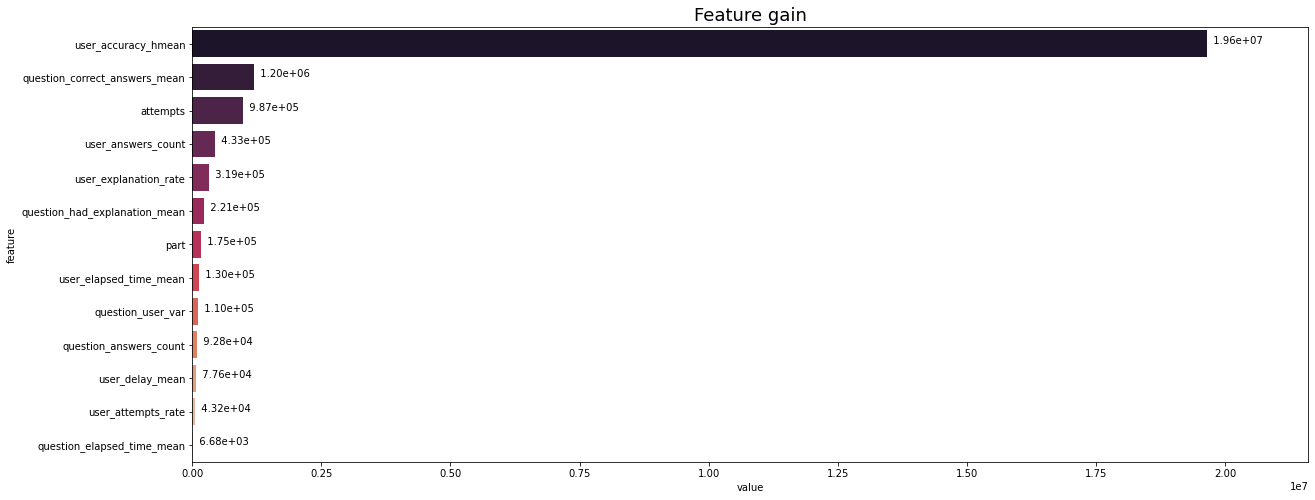

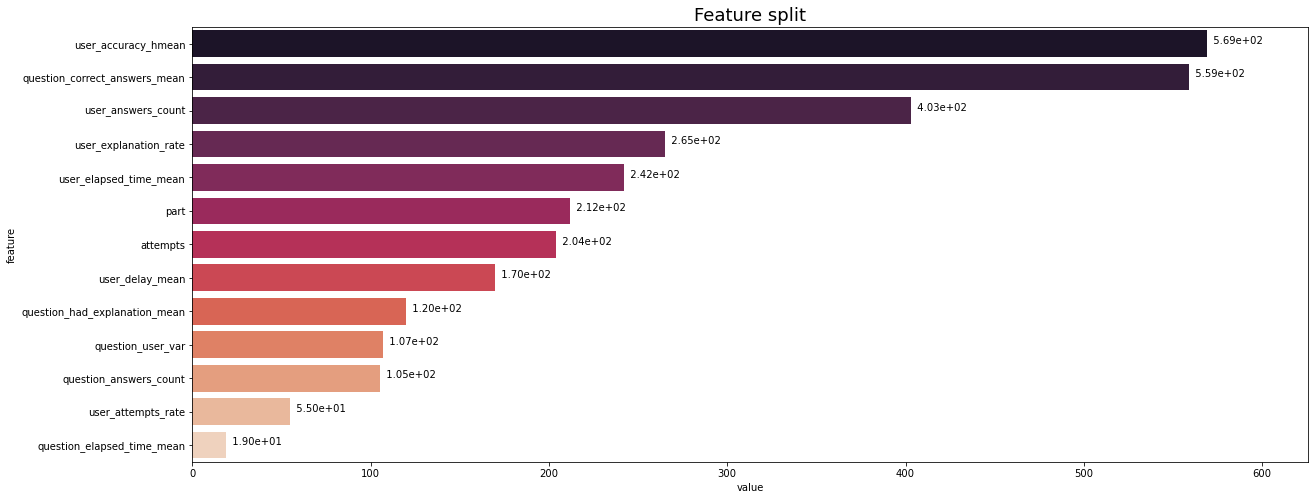

In [10]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = model.feature_name()
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [11]:
model.save_model(os.path.join(user_data_path, 'model_lgbm_cumsum.lgb'))

## Модель для пользователей, которые мало отвечали

In [52]:
train_df_newbie = train_df.loc[train_df.user_bundle_count < 15, :]
train_df_newbie = pd.concat([train_df_newbie, train_newbie_df])
train_df.shape

(10000000, 16)

In [53]:
train_df_newbie = make_features_newbie(train_df)
valid_df_newbie = make_features_newbie(valid_dfs['first_user_answers'])

In [54]:
lgbm_train = lgbm.Dataset(data = train_df_newbie.drop(columns='answered_correctly'),#.iloc[:1000000, :],
                          label = train_df_newbie.loc[:, 'answered_correctly'],#.iloc[:1000000],
                          categorical_feature=['part'],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df_newbie.drop(columns='answered_correctly'),
                          label = valid_df_newbie.loc[:, 'answered_correctly'],
                          categorical_feature=['part'],
                          free_raw_data = False)

In [55]:
params = {#'boosting_type': 'gbdt',
#           'max_depth' : -1,
          'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 100,
#           'learning_rate': 0.1,
#           'subsample': 0.8,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 0.01,
#           'reg_lambda': 100,
          'metric' : 'auc',
          'random_state': 17,
          'num_boost_round': 10000,
          'verbose_eval': 50,
          'early_stopping_rounds': 100
         }
model_newbie = lgbm.train(
    params = params,
    train_set = lgbm_train,
    valid_sets = [lgbm_valid]
)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.707099
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.704969
[3]	valid_0's auc: 0.693382
[4]	valid_0's auc: 0.70604
[5]	valid_0's auc: 0.704336
[6]	valid_0's auc: 0.70604
[7]	valid_0's auc: 0.708753
[8]	valid_0's auc: 0.706421
[9]	valid_0's auc: 0.707693
[10]	valid_0's auc: 0.706485
[11]	valid_0's auc: 0.706179
[12]	valid_0's auc: 0.706869
[13]	valid_0's auc: 0.706419
[14]	valid_0's auc: 0.706962
[15]	valid_0's auc: 0.707251
[16]	valid_0's auc: 0.707397
[17]	valid_0's auc: 0.7073
[18]	valid_0's auc: 0.707392
[19]	valid_0's auc: 0.707449
[20]	valid_0's auc: 0.708331
[21]	valid_0's auc: 0.708208
[22]	valid_0's auc: 0.707637
[23]	valid_0's auc: 0.708434
[24]	valid_0's auc: 0.707647
[25]	valid_0's auc: 0.70681
[26]	valid_0's auc: 0.705335
[27]	valid_0's auc: 0.705504
[28]	valid_0's auc: 0.70515
[29]	valid_0's auc: 0.705896
[30]	valid_0's auc: 0.706205
[31]	valid_0's auc: 0.706541
[32]	valid_0's auc: 0.706994
[33]	valid_0's auc: 0.707

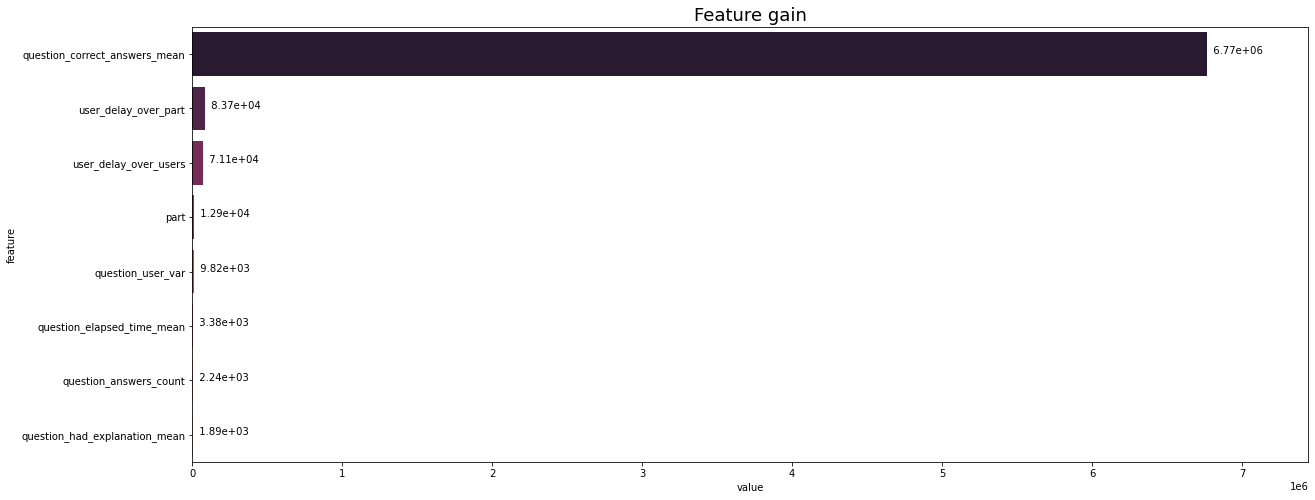

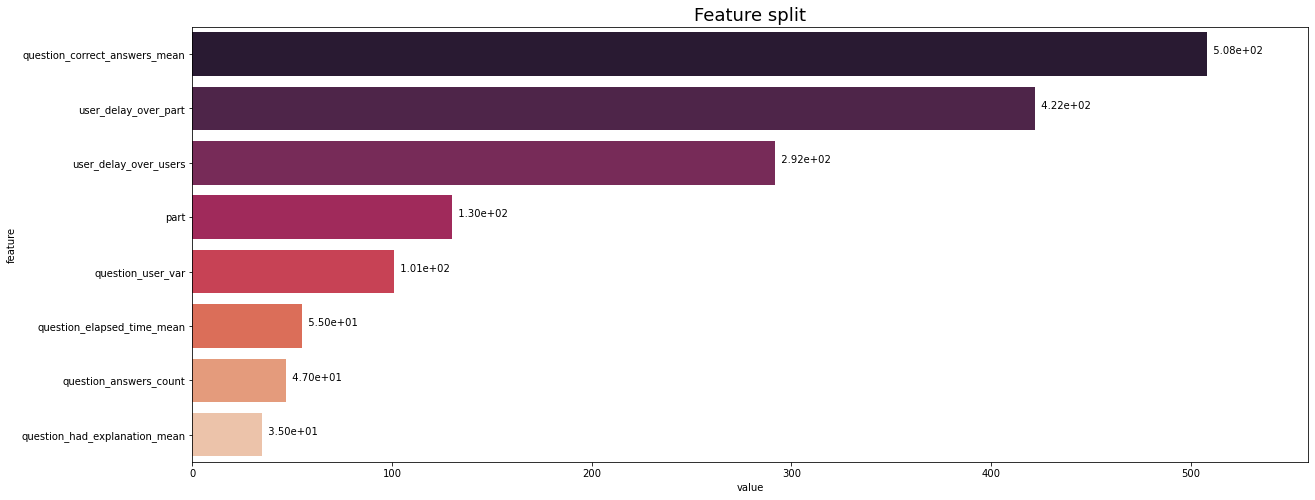

In [69]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = model.feature_name()
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model_newbie, 'gain')
show_feature_importances(model_newbie, 'split')

In [32]:
model.save_model(os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

## Проверка предсказаний

In [64]:
from sklearn.metrics import roc_auc_score

In [76]:
test_df = pd.concat([valid_dfs['first_user_answers'], valid_dfs['last_user_answers']])
ypred = make_prediction(test_df, model_profi, model_newbie, 1)
roc_auc_score(test_df['answered_correctly'], ypred)

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0.740096820470971

# Поиск по сетке параметров

In [24]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'rb') as fo:
    train_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'valid_df.pickle'), 'rb') as fo:
    valid_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'users_characteristics.pickle'), 'rb') as fo:
    users_chars = pickle.load(fo)
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    q_chars = pickle.load(fo)
    
memory_usage(train_df, 'train_df')
memory_usage(valid_df, 'valid_df')
memory_usage(q_chars, 'question_characteristics')
memory_usage(users_chars, 'users_chars')

train_df use 915.53 mb in memory
valid_df use 14.88 mb in memory
question_characteristics use 0.67 mb in memory
users_chars use 18.02 mb in memory


In [25]:
lgbm_train = lgbm.Dataset(data = train_df.drop(columns='answered_correctly').iloc[:1000000, :],
                          label = train_df.loc[:, 'answered_correctly'].iloc[:1000000],
                          categorical_feature=[0],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df.drop(columns='answered_correctly'),
                          label = valid_df.loc[:, 'answered_correctly'],
                          categorical_feature=[0],
                          free_raw_data = False)

In [26]:
def combine_parameters(static_parameters, dynamic_parameters):
    """
    Фнкция составления списка наборов параметров из заданного словаря
    """
    if not dynamic_parameters:
        return static_parameters

    keys = list(dynamic_parameters.keys())
    settings = []

    if len(keys) == 1:
        key = keys[0]
        current_settings = static_parameters
        for param in dynamic_parameters[key]:
            current_settings[key] = param
            settings.append(current_settings.copy())
    else:
        key = keys[0]
        current_settings = static_parameters
        current_dyn_params = dict([(name, val) for name, val in dynamic_parameters.items() if name != key])
        for param in dynamic_parameters[key]:
            current_settings[key] = param

            current_parameters = combine_parameters(current_settings.copy(), current_dyn_params)
            settings += current_parameters

    return settings

In [36]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 38,
          'learning_rate': 0.1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'reg_alpha': 0.01,
          'reg_lambda': 100,
          'metric' : 'auc',
          'random_state': 17,
          'num_boost_round': 2500,
          'verbose_eval': 10,
          'early_stopping_rounds': 10
         }

gridParams = {
#     'learning_rate': [0.01, 0.1, 1.],
    'num_leaves': [10, 30, 100, 500, 1000],
#     'reg_alpha' : [0.001, 0.01, 0.1],
#     'reg_lambda' : [10, 100, 1000],
    }
# NUM_BOOST_ROUND = 2500
# VERBOSE_EVAL = 25

# mdl = lgbm.LGBMClassifier(boosting_type= 'gbdt',
#                         objective = 'binary',
#                         n_jobs = 3, # Updated from 'nthread'
#                         silent = True,
#                         max_depth = params['max_depth'],
#                         max_bin = params['max_bin'],
#                         subsample_for_bin = params['subsample_for_bin'],
#                         subsample = params['subsample'],
#                         subsample_freq = params['subsample_freq'],
#                         min_split_gain = params['min_split_gain'],
#                         min_child_weight = params['min_child_weight'],
#                         min_child_samples = params['min_child_samples'],
#                         scale_pos_weight = params['scale_pos_weight'])
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=4,
#                     n_jobs=2)

In [37]:
score_list = []
param_list = combine_parameters(params, gridParams)

for current_params in param_list:
    model = lgbm.train(params=current_params, train_set = lgbm_train, valid_sets = [lgbm_valid])
    y_predict = model.predict(lgbm_valid.data)
    score_list.append(metrics.roc_auc_score(lgbm_valid.label, y_predict))

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.692812
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.724569
[3]	valid_0's auc: 0.715703
[4]	valid_0's auc: 0.71997
[5]	valid_0's auc: 0.73692
[6]	valid_0's auc: 0.738892
[7]	valid_0's auc: 0.740201
[8]	valid_0's auc: 0.741841
[9]	valid_0's auc: 0.741844
[10]	valid_0's auc: 0.744275
[11]	valid_0's auc: 0.743767
[12]	valid_0's auc: 0.744377
[13]	valid_0's auc: 0.744862
[14]	valid_0's auc: 0.744896
[15]	valid_0's auc: 0.745394
[16]	valid_0's auc: 0.745535
[17]	valid_0's auc: 0.745387
[18]	valid_0's auc: 0.745695
[19]	valid_0's auc: 0.74552
[20]	valid_0's auc: 0.745955
[21]	valid_0's auc: 0.745994
[22]	valid_0's auc: 0.746091
[23]	valid_0's auc: 0.746968
[24]	valid_0's auc: 0.747145
[25]	valid_0's auc: 0.747393
[26]	valid_0's auc: 0.747596
[27]	valid_0's auc: 0.748156
[28]	valid_0's auc: 0.749968
[29]	valid_0's auc: 0.750235
[30]	valid_0's auc: 0.750177
[31]	valid_0's auc: 0.750176
[32]	valid_0's auc: 0.74994
[33]	valid_0's auc: 0.74

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.681786
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.718565
[3]	valid_0's auc: 0.727981
[4]	valid_0's auc: 0.730421
[5]	valid_0's auc: 0.741097
[6]	valid_0's auc: 0.744635
[7]	valid_0's auc: 0.743515
[8]	valid_0's auc: 0.745779
[9]	valid_0's auc: 0.747209
[10]	valid_0's auc: 0.748561
[11]	valid_0's auc: 0.747264
[12]	valid_0's auc: 0.745723
[13]	valid_0's auc: 0.7461
[14]	valid_0's auc: 0.747136
[15]	valid_0's auc: 0.747412
[16]	valid_0's auc: 0.747089
[17]	valid_0's auc: 0.747642
[18]	valid_0's auc: 0.747623
[19]	valid_0's auc: 0.747512
[20]	valid_0's auc: 0.749032
[21]	valid_0's auc: 0.74825
[22]	valid_0's auc: 0.748464
[23]	valid_0's auc: 0.749184
[24]	valid_0's auc: 0.749659
[25]	valid_0's auc: 0.748939
[26]	valid_0's auc: 0.749417
[27]	valid_0's auc: 0.750028
[28]	valid_0's auc: 0.750607
[29]	valid_0's auc: 0.751078
[30]	valid_0's auc: 0.750575
[31]	valid_0's auc: 0.750647
[32]	valid_0's auc: 0.751515
[33]	valid_0's auc: 0.7

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.720445
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.727728
[3]	valid_0's auc: 0.733256
[4]	valid_0's auc: 0.734823
[5]	valid_0's auc: 0.739981
[6]	valid_0's auc: 0.737501
[7]	valid_0's auc: 0.738442
[8]	valid_0's auc: 0.742359
[9]	valid_0's auc: 0.74248
[10]	valid_0's auc: 0.745596
[11]	valid_0's auc: 0.743498
[12]	valid_0's auc: 0.742945
[13]	valid_0's auc: 0.742573
[14]	valid_0's auc: 0.744035
[15]	valid_0's auc: 0.74424
[16]	valid_0's auc: 0.744447
[17]	valid_0's auc: 0.744419
[18]	valid_0's auc: 0.744351
[19]	valid_0's auc: 0.744836
[20]	valid_0's auc: 0.745628
[21]	valid_0's auc: 0.745031
[22]	valid_0's auc: 0.74491
[23]	valid_0's auc: 0.744988
[24]	valid_0's auc: 0.745804
[25]	valid_0's auc: 0.746238
[26]	valid_0's auc: 0.74686
[27]	valid_0's auc: 0.74746
[28]	valid_0's auc: 0.74894
[29]	valid_0's auc: 0.749028
[30]	valid_0's auc: 0.748842
[31]	valid_0's auc: 0.747517
[32]	valid_0's auc: 0.747356
[33]	valid_0's auc: 0.7475

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.720434
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.727214
[3]	valid_0's auc: 0.732699
[4]	valid_0's auc: 0.735086
[5]	valid_0's auc: 0.742749
[6]	valid_0's auc: 0.744609
[7]	valid_0's auc: 0.74561
[8]	valid_0's auc: 0.748619
[9]	valid_0's auc: 0.747815
[10]	valid_0's auc: 0.75022
[11]	valid_0's auc: 0.748768
[12]	valid_0's auc: 0.748999
[13]	valid_0's auc: 0.749721
[14]	valid_0's auc: 0.750914
[15]	valid_0's auc: 0.750595
[16]	valid_0's auc: 0.750312
[17]	valid_0's auc: 0.750298
[18]	valid_0's auc: 0.750141
[19]	valid_0's auc: 0.749613
[20]	valid_0's auc: 0.750569
[21]	valid_0's auc: 0.7503
[22]	valid_0's auc: 0.75088
[23]	valid_0's auc: 0.751288
[24]	valid_0's auc: 0.752302
[25]	valid_0's auc: 0.752791
[26]	valid_0's auc: 0.752898
[27]	valid_0's auc: 0.7537
[28]	valid_0's auc: 0.753799
[29]	valid_0's auc: 0.754115
[30]	valid_0's auc: 0.753966
[31]	valid_0's auc: 0.75394
[32]	valid_0's auc: 0.753603
[33]	valid_0's auc: 0.753266

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.71943
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.727208
[3]	valid_0's auc: 0.731399
[4]	valid_0's auc: 0.736553
[5]	valid_0's auc: 0.744432
[6]	valid_0's auc: 0.7458
[7]	valid_0's auc: 0.746757
[8]	valid_0's auc: 0.749513
[9]	valid_0's auc: 0.7489
[10]	valid_0's auc: 0.750554
[11]	valid_0's auc: 0.748994
[12]	valid_0's auc: 0.747649
[13]	valid_0's auc: 0.747494
[14]	valid_0's auc: 0.749317
[15]	valid_0's auc: 0.74836
[16]	valid_0's auc: 0.747911
[17]	valid_0's auc: 0.747923
[18]	valid_0's auc: 0.748282
[19]	valid_0's auc: 0.748164
[20]	valid_0's auc: 0.749653
Early stopping, best iteration is:
[10]	valid_0's auc: 0.750554


In [38]:
i = np.argmax(score_list)
best_params = dict((key, val) for key, val in param_list[i].items() if key in gridParams.keys())
print('best score {:.5f} on {}'.format(score_list[i], best_params))

best score 0.75944 on {'num_leaves': 100}


In [30]:
%%time
grid.fit(train_df.iloc[:1000000, :], train_df.iloc[:1000000, :]['answered_correctly'])

CPU times: user 5.19 s, sys: 1.33 s, total: 6.52 s
Wall time: 4min 34s


GridSearchCV(cv=4,
             estimator=LGBMClassifier(max_bin=512, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_jobs=3, objective='binary',
                                      scale_pos_weight=1, subsample=1,
                                      subsample_for_bin=200, subsample_freq=1),
             n_jobs=2,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.3, 0.6],
                         'learning_rate': [0.05, 0.5], 'n_estimators': [40],
                         'num_leaves': [3, 6, 8], 'objective': ['binary'],
                         'random_state': [501], 'reg_alpha': [0.1, 1],
                         'reg_lambda': [0.1, 1], 'subsample': [0.4, 0.7]})

In [31]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.3,
 'learning_rate': 0.5,
 'n_estimators': 40,
 'num_leaves': 3,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.4}

In [32]:
model.best_score['valid_0']['auc']

0.7710950884905755

In [108]:
model.save_model(os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

In [110]:
model_2 = lgbm.Booster(model_file=os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

In [112]:
model_2.predict(valid_df)

array([0.67026076, 0.1258083 , 0.1258083 , ..., 0.97617155, 0.57685161,
       0.55882361])

In [113]:
metrics.roc_auc_score(valid_df['answered_correctly'], model_2.predict(valid_df))

0.7807047143355663

In [13]:
# param = {
#         'num_leaves': 80,
#         'max_bin': 250,
#         'min_data_in_leaf': 11,
#         'learning_rate': 0.01,
#         'min_sum_hessian_in_leaf': 0.00245,
#         'bagging_fraction': 1.0, 
#         'bagging_freq': 5, 
#         'feature_fraction': 0.05,
#         'lambda_l1': 4.972,
#         'lambda_l2': 2.276,
#         'min_gain_to_split': 0.65,
#         'max_depth': 14,
#         'save_binary': True,
#         'seed': 1337,
#         'feature_fraction_seed': 1337,
#         'bagging_seed': 1337,
#         'drop_seed': 1337,
#         'data_random_seed': 1337,
#         'objective': 'binary',
#         'boosting_type': 'gbdt',
#         'verbose': 1,
#         'metric': 'auc',
#         'is_unbalance': True,
#         'boost_from_average': False,
#         'device': 'cpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
#     }

posx and posy should be finite values
posx and posy should be finite values


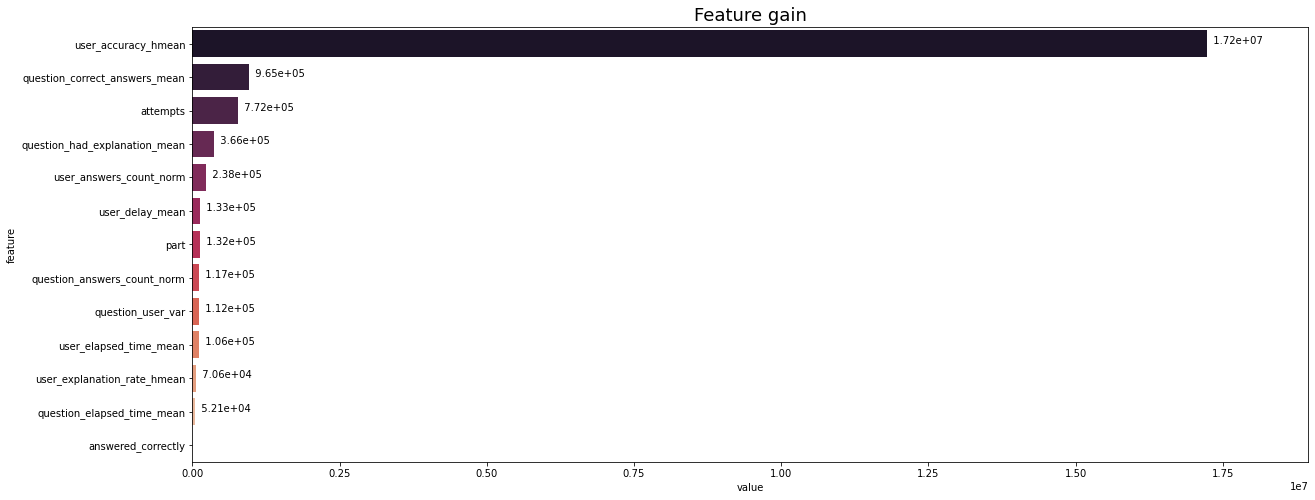

posx and posy should be finite values
posx and posy should be finite values


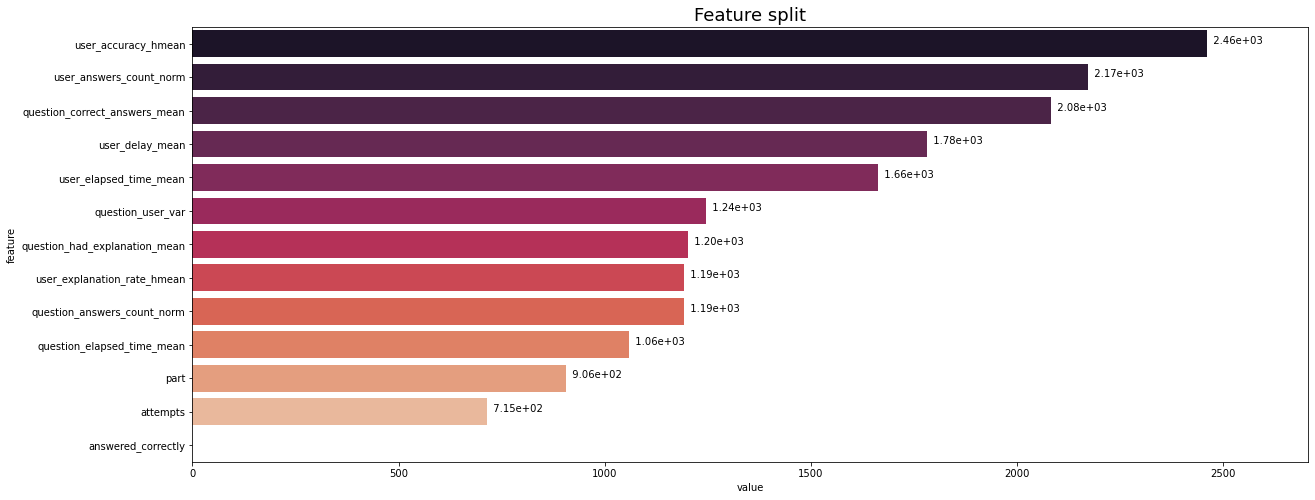

In [92]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = train_df.columns
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [85]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(valid_df)

SHAPError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

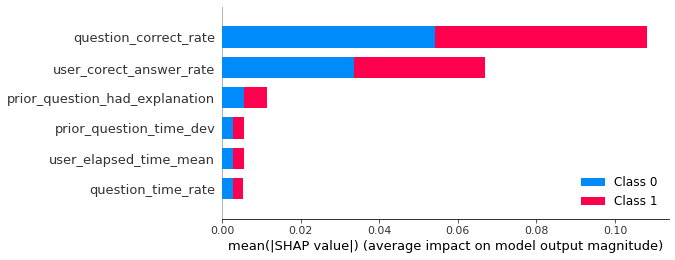

In [18]:
shap.summary_plot(shap_values, valid_features_df, plot_type="bar",
                  title = "")

# Predictions

In [23]:
import riiideducation
env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation'

In [ ]:
# Here you would also add your pretrained model
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    # --- PREPROCESSING ---
    # Here is time to apply the preprocessing to the test_df
    test_df = merge_data(test_df, questions_df, data_type='test')
    test_df, last_answers = get_answer_time_characteristics(test_df, last_answers)
    test_df = get_features_df(test_df, q_chars, questions_df)
    
    # --- MODEL ---
    test_df['answered_correctly'] = lgbm_2.predict(test_df, num_iteration = lgbm_2.best_iteration)
    env.predict(test_df.reset_index()[['row_id', 'answered_correctly']])

In [32]:
df = pd.DataFrame({
    'a': ['1', '1', '1'],
    'b': [2, np.nan, np.nan]
})
df.drop_duplicates()

,a,b
0,1,2.0
1,1,NaN
